# Music Hits Linear Regression Project

#### This notebook will create and test a linear regressions model on billboard 200 charts data, merged with various musical data scraped from wikipedia, notediscover, and spotify's API python package *spotipy*. 

The following will be done in a new notebook:

1. Fitting a model and visualizations
    * fit a linear regression model
    * find error values
    * provide visualizations
2. Testing our model on testing data (Repeating some parts of step 1)
    * create a testing dataset
    * run a test on our test dataset

##### Import necessary libraries.


In [91]:
import requests
from bs4 import BeautifulSoup
import time, os
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold

import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
%matplotlib inline

#setting up Spotipy for spotify importing
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import json

client_id='65345a7007f24e969de028910a832395'
client_secret='1e7eab7392d947039426ecd1a5ec56c2'
spotify = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials(client_id,client_secret))

##### Import dataframe.


In [4]:
df=pd.read_csv('/Users/mehikapatel/MusicHits_Project/data/data\Music_Data.csv')
df.drop(axis=1,labels=['Unnamed: 0'],inplace=True)

Final Adjustments to DataFrame:

In [11]:
# peak_str_list=list(df.peak)

# new_peaks_list=[]

# for peak in peak_str_list:
#     if peak[:3]=='100':
#         new_peaks_list.append(int(peak[:3]))
#     else:
#         new_peaks_list.append(int(peak[:2]))
        
# final_frames=[df,pd.DataFrame(new_peaks_list)]
# df=pd.concat(final_frames,axis=1)
# df.rename(columns={0:'Peak'},inplace=True)
# df.drop(columns=['peak'],inplace=True)
# # df.to_csv(r'/Users/mehikapatel/MusicHits_Project/data\Music_Data.csv')


In [78]:
# to get spotify links for each song:
def spotify_search(song,artist): 

    track_id = spotify.search(q='artist:' + artist + ' track:' + song, type='track')
    #gets link for artist page
    return track_id['tracks']['items'][0]['album']['artists'][0]['external_urls']['spotify']

def get_genre(song,artist):
    genre =spotify.artist(spotify_search(song,artist))['genres']
    return genre

In [83]:
# song_list=list(df.song)
# artist_list=list(df.artist)
# genres_list=[]

# new_artists_list=[]

# for artist in artist_list:
#     word_count=artist.count(' ')
#     if word_count>2:
#         a=artist.split(' ',1)[0]
#         b=artist.split(' ',2)[1]
#         new= a+ ' ' + b
#         new_artists_list.append(new)
#     else:
#         new_artists_list.append(artist)

In [82]:
# #get genres

# for i in range(len(song_list)):
#     genre_list.append(get_genre(song_list[i],new_artists_list[i]))
    
# # genres_df=pd.DataFrame(genre_list)
# # frames=[df,genres_df]

Split Data into Training and Testing Data.

Heatmap and correlated values for initial exploration.

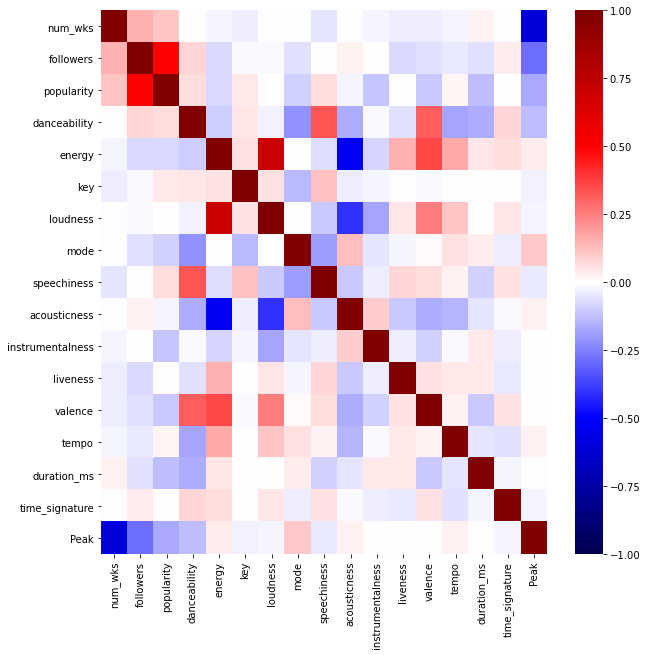

In [79]:
f, ax = plt.subplots(figsize=(10, 10))

sns.heatmap(df.corr(), cmap="seismic", vmin=-1, vmax=1);

In [80]:
df.corr()['Peak'].sort_values(ascending=False)

Peak                1.000000
mode                0.104750
energy              0.033865
tempo               0.026455
acousticness        0.025188
instrumentalness    0.004007
valence             0.003806
liveness            0.001646
duration_ms        -0.007751
loudness           -0.020200
time_signature     -0.022993
key                -0.026587
speechiness        -0.042047
danceability       -0.128626
popularity         -0.169886
followers          -0.287571
num_wks            -0.600483
Name: Peak, dtype: float64

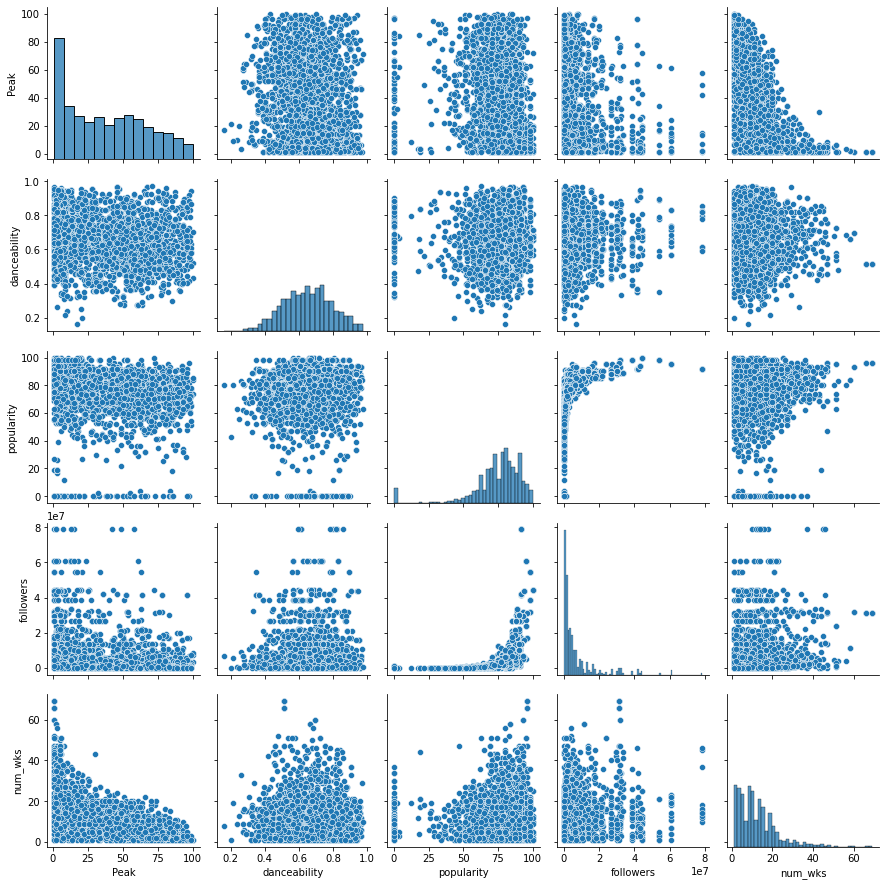

In [83]:
# ['Peak','mode','energy','tempo','acousticness','instrumentalness','valence','liveness','duration_ms',
#                  'loudness','time_signature','key','speechiness','danceability','popularity','followers','num_wks']

sns.pairplot(df[['Peak','danceability','popularity','followers','num_wks']])

In [84]:
x_df = df[['danceability','popularity','followers','num_wks']]
y_df = df['Peak']
lsm = LinearRegression()
sk_fit = lsm.fit(x_df, y_df)
sk_fit.score(x_df, y_df)

0.41176681832416095

In [85]:
print(1-(1-sk_fit.score(x_df, y_df))*((len(x_df)-1)/(len(x_df)-len(x_df.columns)-1)))

0.4109130691490146


Try transforming peak because it is skewed.

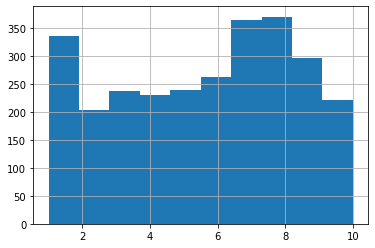

In [89]:
# take log of price and graph
df['log_peak']=np.sqrt(df.Peak)
# looks better
df.log_peak.hist();

In [99]:
x_df = df[['danceability','popularity','followers','num_wks']]
y_df = df['Peak']
lsm = LinearRegression()
sk_fit = lsm.fit(x_df, y_df)
sk_fit.score(x_df, y_df)

0.41176681832416095

In [90]:
lm1 = smf.ols('log_peak ~ danceability + popularity + followers + num_wks', data=df)

# Fit the model
fit1 = lm1.fit()

# Print summary statistics of the model's performance
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               log_peak   R-squared:                       0.462
Model:                            OLS   Adj. R-squared:                  0.461
Method:                 Least Squares   F-statistic:                     591.3
Date:                Tue, 13 Apr 2021   Prob (F-statistic):               0.00
Time:                        16:16:49   Log-Likelihood:                -5723.0
No. Observations:                2761   AIC:                         1.146e+04
Df Residuals:                    2756   BIC:                         1.149e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        9.2496      0.236     39.204      0.000       8.787       9.712
danceability    -2.3253      0.259     -8.982      0.000      -2.833      -1.818
popularity       0.0028      0.002      1.174      0.241      -0.002       0.007
followers    -5.031e-08   3.55e-09    -14.168      0.000   -5.73e-08   -4.33e-08
num_wks         -0.1567      0.004    -41.916      0.000      -0.164      -0.149
==============================================================================
Omnibus:                       82.260   Durbin-Watson:                   0.774
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               87.099
Skew:                          -0.421   Prob(JB):                     1.22e-19
Kurtosis:                       2.784   Cond. No.                     1.26e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.26e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

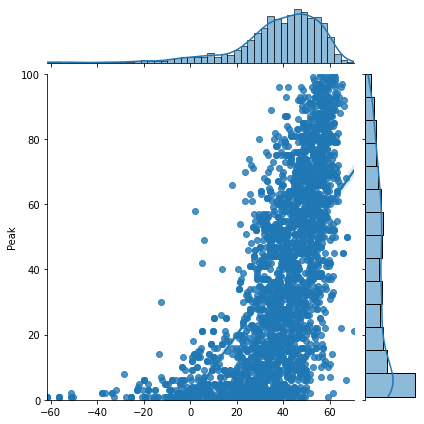

In [101]:
preds = sk_fit.predict(x_df) # generate predictions (on training data) using fit model

sns.jointplot(x=preds,y=y_df, kind='reg',ylim=(0,100))

In [103]:
print(lsm.intercept_)
print(lsm.coef_)

76.58057597424192
[-2.20456840e+01 -3.34024259e-03 -4.46892208e-07 -1.62902865e+00]


Recall that this means the model we've fit is given by:

$$y_{pred} = f(x) = 76.58 - 22x_{danceability} -.003x_{popularity} - 1.6x_{numwks}$$

In [95]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

#predicted values
preds = sk_fit.predict(x_df) 
#some error measurements

def SSE(actuals, preds):
    return np.sum((actuals - preds)**2)

RMSE = mean_squared_error(y_df, preds, squared=False)
MAE = mean_absolute_error(y_df, preds)
def SST(y):
    return np.sum((y - np.mean(y))**2)

def R2(actuals, preds):
    return 1 - SSE(actuals, preds) / SST(actuals)

In [106]:
MAE(y_df,preds)

TypeError: 'numpy.float64' object is not callable